# Flight Price Prediction






## Loading libraries:

In [ ]:
# Install pyspark
!pip install pyspellchecker
!pip install pyspark
!pip install openpyxl
import warnings
warnings.filterwarnings("ignore")
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!apt-get -qq install -y libarchive-dev && pip install -U libarchive

!apt-get -qq install -y graphviz && pip install pydot
import pydot
!pip install cartopy
import cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=edc231078fd11d8e0cd95abfb9e99fca689fcd7376106a7de3483c662a6069d1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
E: Package 'libfluidsynth1' has no installation candidate
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 121747 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark import SparkContext, SparkConf
conf = SparkConf()
conf.set('spark.sql.autoBroadcastJoinThreshold',-1)

In [ ]:
# More libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Lets import our Data:



In [ ]:
df = pd.read_csv('Dataset.csv')
df = df.drop(['Unnamed: 0', 'flight'], axis = 1)
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Visualisations

### Hypothesis Tests:

1. Does the price vary with Airlines?

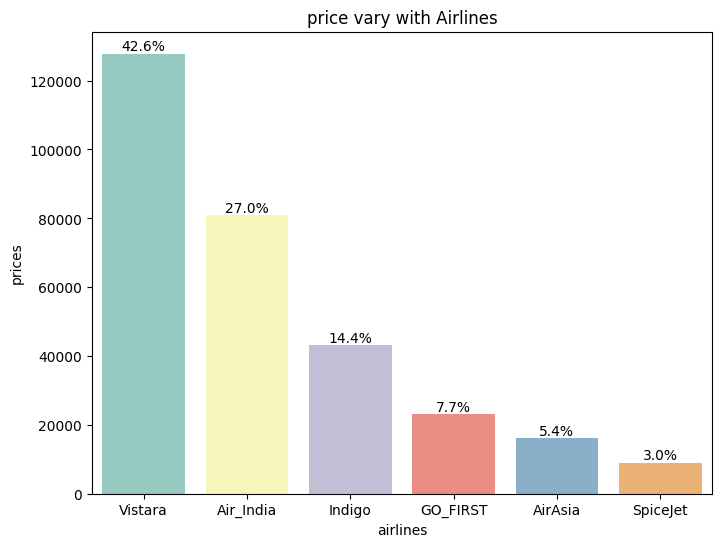

In [ ]:
data = df
dm = data['airline'].value_counts()
total_customers = len(data)

percentages = dm / total_customers * 100

# Choose a different color palette from Seaborn
colors = sns.color_palette('Set3', n_colors=len(dm))

plt.figure(figsize=(8, 6))
sns.barplot(x=dm.index, y=dm, palette=colors)

for i, p in enumerate(plt.gca().patches):
    percentage = '{:.1f}%'.format(percentages[i])
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.5
    plt.text(x, y, percentage, ha='center', va='bottom', fontsize=10, color='black')

plt.title('price vary with Airlines')
plt.xlabel('airlines')
plt.ylabel('prices')

plt.show()

2. How does the ticket price vary between Economy and Business class?

<Axes: title={'center': 'vary between class'}, ylabel='price'>

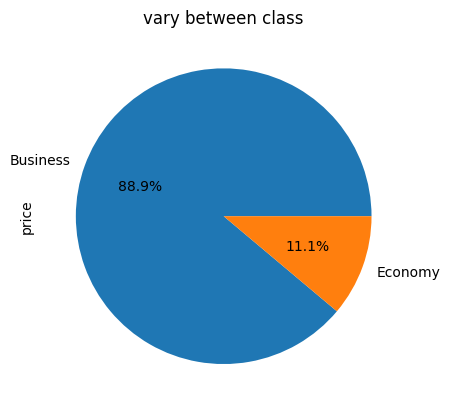

In [ ]:
data.groupby(['class'])['price'].mean().plot(kind='pie',title='vary between class',autopct = "%1.1f%%")

Text(0.5, 1.0, 'airlines based on Business')

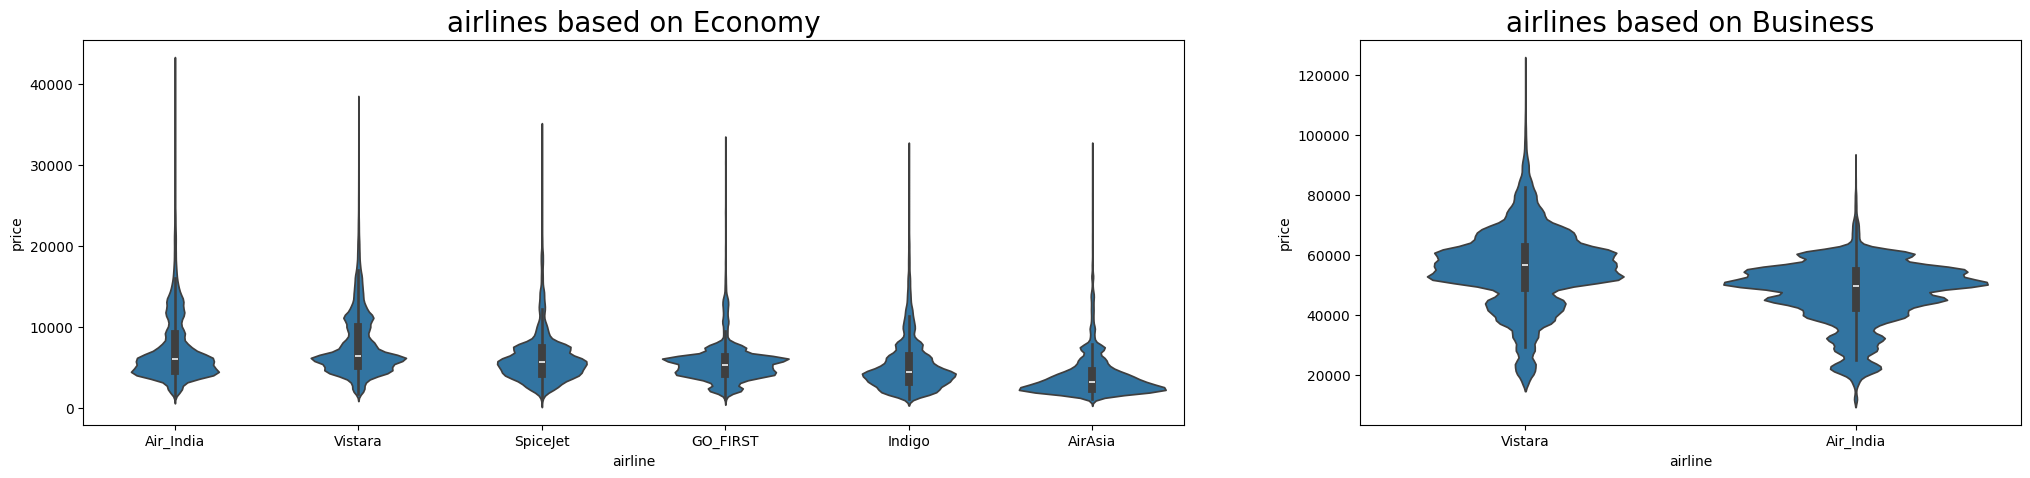

In [ ]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.violinplot(x='airline',y='price',data=data.loc[data['class']=='Economy'].sort_values(by='price',ascending=False),ax=axs[0])
axs[0].set_title('airlines based on Economy',fontsize=20)
sns.violinplot(x='airline',y = 'price',data=data.loc[data['class']=='Business'].sort_values(by ='price',ascending = False),ax=axs[1])
axs[1].set_title('airlines based on Business',fontsize=20)

3. How does the price change with the change in Source or Destination?

Text(0.5, 0.98, 'price vary with source and destination city')

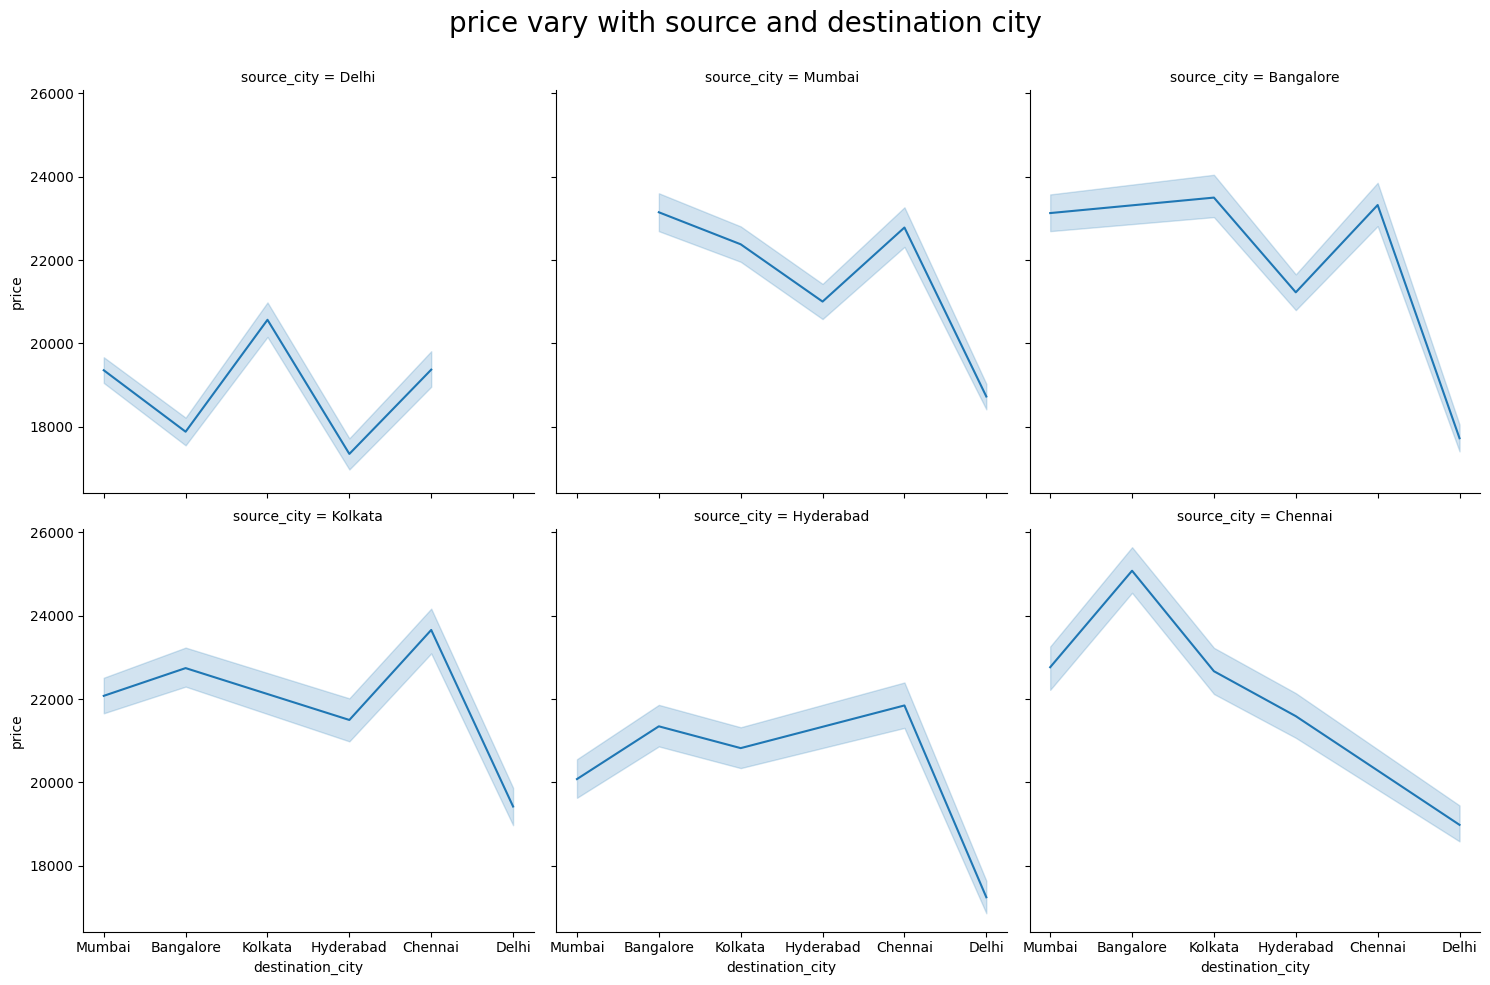

In [ ]:
mx = sns.relplot(col ='source_city',y='price',kind = 'line',x='destination_city',data=data,col_wrap=3 )
mx.fig.subplots_adjust(top=0.9)
mx.fig.suptitle('price vary with source and destination city', fontsize=20)

4. Does ticket price change based on the departure time and arrival time?

Text(0.5, 1.0, 'airline prices based on Arrival Time')

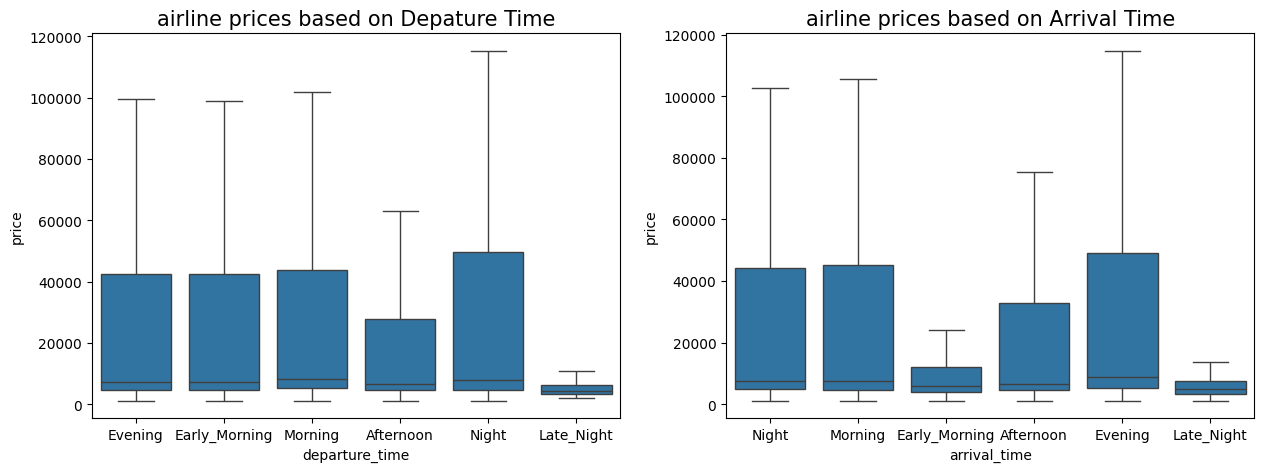

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=data, x='departure_time',y='price',showfliers=False).set_title('airline prices based on Depature Time',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(data=data,x='arrival_time',y ='price',showfliers=False).set_title('airline prices based on Arrival Time',fontsize=15)

### Data Preparation:

In [ ]:
from pyspark.sql.types import *
df_schema = StructType([StructField('airline', StringType(), True), StructField('source_city', StringType(), True),
                        StructField('departure_time', StringType(), True), StructField('stops', StringType(), True),
                        StructField('arrival_time', StringType(), True), StructField('destination_city', StringType(), True),
                        StructField('class', StringType(), True),
                        StructField('duration', FloatType(), True), StructField('days_left', IntegerType(), True),
                        StructField('price', IntegerType(), True)])
data = spark.createDataFrame(df,schema=df_schema)

In [ ]:
data.printSchema()

root
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: float (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



In [ ]:
type(data)

pyspark.sql.dataframe.DataFrame

In [ ]:
data.toPandas()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [ ]:
from pyspark.sql.functions import col,isnan, when, count

In [ ]:
# Checking for NA's
data.select([count(when((col(c) == '') |isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = data

In [ ]:
df.count()

300153

In [ ]:
from pyspark.sql.functions import *
from datetime import datetime
import pyspark.sql.functions as sqlFunc
import pyspark.sql.types as types
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp

In [ ]:
df.printSchema()

root
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: float (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



Lets handle our categorical data (sting variables)

In [ ]:
df.groupBy('airline').count().alias('Count').sort(col('Count').desc()).show()

+---------+------+
|  airline| count|
+---------+------+
|  Vistara|127859|
|Air_India| 80892|
|   Indigo| 43120|
| GO_FIRST| 23173|
|  AirAsia| 16098|
| SpiceJet|  9011|
+---------+------+



In [ ]:
import pyspark.sql.functions as F
categ_air = df.select('airline').distinct().rdd.flatMap(lambda x:x).collect()
exprs_air = [F.when(F.col('airline') == cat,1).otherwise(0).alias(str(cat)) for cat in categ_air]
df = df.select(exprs_air + df.columns)

In [ ]:
df.groupBy('source_city').count().alias('Count').sort(col('Count').desc()).show()

+-----------+-----+
|source_city|count|
+-----------+-----+
|      Delhi|61343|
|     Mumbai|60896|
|  Bangalore|52061|
|    Kolkata|46347|
|  Hyderabad|40806|
|    Chennai|38700|
+-----------+-----+



In [ ]:
categ_sou = df.select('source_city').distinct().rdd.flatMap(lambda x:x).collect()
exprs_sou = [F.when(F.col('source_city') == cat,1).otherwise(0).alias(str(cat)+'_Sour') for cat in categ_sou]
df = df.select(exprs_sou+df.columns)

In [ ]:
df.groupBy('departure_time').count().alias('Count').sort(col('Count').desc()).show()

+--------------+-----+
|departure_time|count|
+--------------+-----+
|       Morning|71146|
| Early_Morning|66790|
|       Evening|65102|
|         Night|48015|
|     Afternoon|47794|
|    Late_Night| 1306|
+--------------+-----+



In [ ]:
categ_dep = df.select('departure_time').distinct().rdd.flatMap(lambda x:x).collect()
exprs_dep = [F.when(F.col('departure_time') == cat,1).otherwise(0).alias(str(cat)+'_Dep') for cat in categ_dep]
df = df.select(exprs_dep +df.columns)

In [ ]:
df.groupBy('stops').count().alias('Count').sort(col('Count').desc()).show()

+-----------+------+
|      stops| count|
+-----------+------+
|        one|250863|
|       zero| 36004|
|two_or_more| 13286|
+-----------+------+



In [ ]:
categ_sto = df.select('stops').distinct().rdd.flatMap(lambda x:x).collect()
exprs_sto = [F.when(F.col('stops') == cat,1).otherwise(0).alias(str(cat)+'_sto') for cat in categ_sto]
df = df.select(exprs_sto +df.columns)

In [ ]:
df.groupBy('arrival_time').count().alias('Count').sort(col('Count').desc()).show()

+-------------+-----+
| arrival_time|count|
+-------------+-----+
|        Night|91538|
|      Evening|78323|
|      Morning|62735|
|    Afternoon|38139|
|Early_Morning|15417|
|   Late_Night|14001|
+-------------+-----+



In [ ]:
categ_arr = df.select('arrival_time').distinct().rdd.flatMap(lambda x:x).collect()
exprs_arr = [F.when(F.col('arrival_time') == cat,1).otherwise(0).alias(str(cat)+'_arr') for cat in categ_arr]
df = df.select(exprs_arr +df.columns)

In [ ]:
df.groupBy('destination_city').count().alias('Count').sort(col('Count').desc()).show()

+----------------+-----+
|destination_city|count|
+----------------+-----+
|          Mumbai|59097|
|           Delhi|57360|
|       Bangalore|51068|
|         Kolkata|49534|
|       Hyderabad|42726|
|         Chennai|40368|
+----------------+-----+



In [ ]:
categ_des = df.select('destination_city').distinct().rdd.flatMap(lambda x:x).collect()
exprs_des = [F.when(F.col('destination_city') == cat,1).otherwise(0).alias(str(cat)+'_Des') for cat in categ_des]
df = df.select(exprs_des +df.columns)

In [ ]:
df.groupBy('class').count().alias('Count').sort(col('Count').desc()).show()

+--------+------+
|   class| count|
+--------+------+
| Economy|206666|
|Business| 93487|
+--------+------+



In [ ]:
categ_cla = df.select('class').distinct().rdd.flatMap(lambda x:x).collect()
exprs_cla = [F.when(F.col('class') == cat,1).otherwise(0).alias(str(cat)+'_cla') for cat in categ_cla]
df = df.select(exprs_cla +df.columns)

In [ ]:
df = df.drop('airline')
df = df.drop('source_city')
df = df.drop('stops')
df = df.drop('destination_city')
df = df.drop('class')
df = df.drop('flight')
df = df.drop('departure_time')
df = df.drop('arrival_time')

In [ ]:
df.printSchema()

root
 |-- Economy_cla: integer (nullable = false)
 |-- Business_cla: integer (nullable = false)
 |-- Bangalore_Des: integer (nullable = false)
 |-- Chennai_Des: integer (nullable = false)
 |-- Mumbai_Des: integer (nullable = false)
 |-- Kolkata_Des: integer (nullable = false)
 |-- Delhi_Des: integer (nullable = false)
 |-- Hyderabad_Des: integer (nullable = false)
 |-- Evening_arr: integer (nullable = false)
 |-- Morning_arr: integer (nullable = false)
 |-- Late_Night_arr: integer (nullable = false)
 |-- Afternoon_arr: integer (nullable = false)
 |-- Early_Morning_arr: integer (nullable = false)
 |-- Night_arr: integer (nullable = false)
 |-- two_or_more_sto: integer (nullable = false)
 |-- one_sto: integer (nullable = false)
 |-- zero_sto: integer (nullable = false)
 |-- Evening_Dep: integer (nullable = false)
 |-- Morning_Dep: integer (nullable = false)
 |-- Late_Night_Dep: integer (nullable = false)
 |-- Afternoon_Dep: integer (nullable = false)
 |-- Early_Morning_Dep: integer (null

In [ ]:
df = df.withColumn('price',
              F.when((df['price'] >=40000),
              F.round(F.lit(df.select(F.mean(F.col('price')).alias('mean')).collect()[0]['mean'])).cast('Integer')).otherwise(F.col('Price')))

## Build model and pipeline

In [ ]:
# Split data to Data Train and Data Test
(trainDF, testDF) = df.randomSplit([.8, .2], seed=1)

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Economy_cla', 'Business_cla',
                                       'Bangalore_Des', 'Chennai_Des', 'Mumbai_Des', 'Kolkata_Des','Delhi_Des', 'Hyderabad_Des',
                                       'Evening_arr', 'Morning_arr', 'Late_Night_arr', 'Afternoon_arr', 'Early_Morning_arr', 'Night_arr',
                                       'two_or_more_sto', 'one_sto', 'zero_sto',
                                       'Evening_Dep', 'Morning_Dep', 'Late_Night_Dep', 'Afternoon_Dep', 'Early_Morning_Dep', 'Night_Dep',
                                       'Bangalore_Sour', 'Mumbai_Sour', 'Kolkata_Sour', 'Delhi_Sour', 'Chennai_Sour', 'Hyderabad_Sour',
                                       'Indigo', 'SpiceJet', 'Air_India', 'AirAsia', 'GO_FIRST', 'Vistara',
                                       'duration', 'days_left'], outputCol='features')
assembler_train = assembler.setHandleInvalid("skip").transform(trainDF)
final_train = assembler_train.select('features','price')
final_train.show(3)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(37,[0,7,13,16,22...|10470|
|(37,[0,7,13,16,22...| 6060|
|(37,[0,7,13,16,22...| 7530|
+--------------------+-----+
only showing top 3 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString

In [ ]:
# Decision Tree
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='price')

In [ ]:
# RandomForest
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor(featuresCol = 'features', labelCol='price', maxDepth=5, numTrees=100)

In [ ]:
# Gradient-Boosted Trees
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol='price')

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
stages_ = [dt, rfr, gbt]

In [ ]:
for stage in stages_:

    #build pipeline for each method
    pipeline = Pipeline(stages=[assembler, stage])

    # fit model
    #stage.setMaxBins(40)

    model = pipeline.fit(trainDF)

    # predict and evaluate model

    predictions = model.transform(testDF)

    predictions.select("prediction","price", "features").show(5)

    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

    # RMSE
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # R squared
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"}) * 100
    print("R Squared (R^2) on test data = %g" % r2)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
|7113.0056325823225| 5955|(37,[0,7,13,16,22...|
|7113.0056325823225| 5955|(37,[0,7,13,16,22...|
|7113.0056325823225| 2465|(37,[0,7,13,16,22...|
|3751.0849697192143| 2022|(37,[0,7,13,16,22...|
|3751.0849697192143| 2022|(37,[0,7,13,16,22...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 3016.48
R Squared (R^2) on test data = 87.0396
+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 6223.570660607855| 5955|(37,[0,7,13,16,22...|
| 6223.570660607855| 5955|(37,[0,7,13,16,22...|
| 6134.064028013819| 2465|(37,[0,7,13,16,22...|
|3723.5454501007057| 2022|(37,[0,7,13,16,22...|
|3723.5454501007057| 2022|(37,[0,7,13,16,22...|
+------------------+-----+--------------------+
only showing top 5

## Hyperparameter tuning

Decision Tree

In [ ]:
maxDepth = []
for i in range(1,10):
  maxDepth.append(i)

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

paramGrid_dt = (ParamGridBuilder().addGrid(dt.maxDepth, maxDepth).build())
# evaluate model by R2
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName='rmse')

pipeline = Pipeline(stages=[assembler, dt])

cvdt = CrossValidator(estimator=pipeline,evaluator = evaluator,
                    estimatorParamMaps = paramGrid_dt,
                    numFolds=3,seed=42)

# fit on TrainDF
dt.setMaxBins(40)

Modeldt = cvdt.fit(trainDF)

print(pd.DataFrame(list(zip(Modeldt.getEstimatorParamMaps(), Modeldt.avgMetrics)) ,
                     columns=['Regression','RMSE']).sort_values(by="RMSE"))

                                          Regression         RMSE
8  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 9}  2472.197610
7  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 8}  2568.845390
6  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 7}  2683.398462
5  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 6}  2806.498192
4  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 5}  3011.362258
3  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 4}  3140.517857
2  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 3}  3254.806238
1  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 2}  3428.047268
0  {DecisionTreeRegressor_f54aafae3f19__maxDepth: 1}  4028.083803


In [ ]:
preddt = Modeldt.transform(testDF)
evaluatordt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# R squared
r2 = evaluatordt.evaluate(preddt, {evaluatordt.metricName: "r2"}) * 100
print("R Squared (R^2) on test data = %g" % r2)

R Squared (R^2) on test data = 91.5292


Random Forest

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

paramGrid_rfr = ParamGridBuilder().addGrid(rfr.numTrees, [10,100]) \
    .addGrid(rfr.maxDepth, maxDepth) \
    .build()
# evaluate model by R2
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName='rmse')

pipeline = Pipeline(stages=[assembler, rfr])

cvrf = CrossValidator(estimator=pipeline,evaluator = evaluator,
                    estimatorParamMaps = paramGrid_rfr,
                    numFolds=3,seed=42)

# fit on TrainDF
rfr.setMaxBins(40)

Modelrf = cvrf.fit(trainDF)

print(pd.DataFrame(list(zip(Modelrf.getEstimatorParamMaps(), Modelrf.avgMetrics)) ,
                     columns=['Regression','RMSE']).sort_values(by="RMSE"))

                                           Regression         RMSE
17  {RandomForestRegressor_fa023fd80ee6__numTrees:...  2521.645208
8   {RandomForestRegressor_fa023fd80ee6__numTrees:...  2553.333094
16  {RandomForestRegressor_fa023fd80ee6__numTrees:...  2633.420418
7   {RandomForestRegressor_fa023fd80ee6__numTrees:...  2666.979412
15  {RandomForestRegressor_fa023fd80ee6__numTrees:...  2752.096740
6   {RandomForestRegressor_fa023fd80ee6__numTrees:...  2790.838043
14  {RandomForestRegressor_fa023fd80ee6__numTrees:...  2880.984267
5   {RandomForestRegressor_fa023fd80ee6__numTrees:...  2926.995799
13  {RandomForestRegressor_fa023fd80ee6__numTrees:...  3024.155823
4   {RandomForestRegressor_fa023fd80ee6__numTrees:...  3051.196839
12  {RandomForestRegressor_fa023fd80ee6__numTrees:...  3184.541036
3   {RandomForestRegressor_fa023fd80ee6__numTrees:...  3224.298461
2   {RandomForestRegressor_fa023fd80ee6__numTrees:...  3353.265247
11  {RandomForestRegressor_fa023fd80ee6__numTrees:...  3363.69

In [ ]:
predrf = Modelrf.transform(testDF)
evaluatorrf = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# R squared
r3 = evaluatorrf.evaluate(predrf, {evaluatorrf.metricName: "r2"}) * 100
print("R Squared (R^2) on test data = %g" % r3)

R Squared (R^2) on test data = 91.0335


## Feature Importances

In [ ]:
best_rf_model = Modelrf.bestModel.stages[-1]
importances = best_rf_model.featureImportances
feature_list = ['Economy_cla', 'Business_cla',
                'Bangalore_Des', 'Chennai_Des', 'Mumbai_Des', 'Kolkata_Des','Delhi_Des', 'Hyderabad_Des',
                'Evening_arr', 'Morning_arr', 'Late_Night_arr', 'Afternoon_arr', 'Early_Morning_arr', 'Night_arr',
                'two_or_more_sto', 'one_sto', 'zero_sto',
                'Evening_Dep', 'Morning_Dep', 'Late_Night_Dep', 'Afternoon_Dep', 'Early_Morning_Dep', 'Night_Dep',
                'Bangalore_Sour', 'Mumbai_Sour', 'Kolkata_Sour', 'Delhi_Sour', 'Chennai_Sour', 'Hyderabad_Sour',
                'Indigo', 'SpiceJet', 'Air_India', 'AirAsia', 'GO_FIRST', 'Vistara',
                'duration', 'days_left']

print("Feature Importances:")
for feature, importance in zip(feature_list, importances):
    print(f"{feature}: {importance:.4f}")

Feature Importances:
Economy_cla: 0.5314
Business_cla: 0.2970
Bangalore_Des: 0.0019
Chennai_Des: 0.0009
Mumbai_Des: 0.0010
Kolkata_Des: 0.0013
Delhi_Des: 0.0023
Hyderabad_Des: 0.0029
Evening_arr: 0.0009
Morning_arr: 0.0005
Late_Night_arr: 0.0003
Afternoon_arr: 0.0007
Early_Morning_arr: 0.0016
Night_arr: 0.0004
two_or_more_sto: 0.0019
one_sto: 0.0037
zero_sto: 0.0065
Evening_Dep: 0.0004
Morning_Dep: 0.0007
Late_Night_Dep: 0.0000
Afternoon_Dep: 0.0004
Early_Morning_Dep: 0.0005
Night_Dep: 0.0010
Bangalore_Sour: 0.0024
Mumbai_Sour: 0.0008
Kolkata_Sour: 0.0017
Delhi_Sour: 0.0024
Chennai_Sour: 0.0010
Hyderabad_Sour: 0.0028
Indigo: 0.0111
SpiceJet: 0.0007
Air_India: 0.0071
AirAsia: 0.0094
GO_FIRST: 0.0028
Vistara: 0.0177
duration: 0.0189
days_left: 0.0630
